# Description
This kernel creates an image dataset for train based on the competition data. Use of images allows to avoid loading the entire dataset into memory, which may be important for running experiments at kaggle. Meanwhile the inference can be done  by loading the dataset part by part without saving it as images to improve the speed.

The original images are cropped keeping only the characters and resized to 128x128 with adding the corresponding padding to maintain the aspect ratio (see images plot in the kernel). The stats of the produced images are also computed.

find at: https://www.kaggle.com/iafoss/image-preprocessing-128x128

In [ ]:
import cv2
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

TRAIN = ['../bengaliai-cv19/train_image_data_0.parquet',
         '../bengaliai-cv19/train_image_data_1.parquet',
         '../bengaliai-cv19/train_image_data_2.parquet',
         '../bengaliai-cv19/train_image_data_3.parquet']

OUT_TRAIN = 'train.zip'


TEST = ['../bengaliai-cv19/test_image_data_0.parquet',
         '../bengaliai-cv19/test_image_data_1.parquet',
         '../bengaliai-cv19/test_image_data_2.parquet',
         '../bengaliai-cv19/test_image_data_3.parquet']

OUT_TEST = 'test.zip'

In [ ]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [ ]:
df = pd.read_parquet(TRAIN[0])
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()

In [ ]:
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TEST, 'w') as img_out:
    for fname in TEST:
        df = pd.read_parquet(fname)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)
        
            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean()) 
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(name + '.png', img)

In [ ]:
#image stats
img_avr =  np.array(x_tot).mean()
img_std =  np.sqrt(np.array(x2_tot).mean() - img_avr**2)
print('mean:',img_avr, ', std:', img_std)

In [ ]:
df = pd.read_csv("../bengaliai-cv19/test.csv")

In [ ]:
df

In [ ]:
# Notes 
# 168 grapheme roots 
# 11 vowel diacritics 
# 8 consonant diacritics

In [ ]:
df.shape

In [15]:
from __future__ import unicode_literals
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='kalpurush ANSI.ttf')
matplotlib.rcParams['font.family'] = prop.get_name()

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""    
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    titles = titles.numpy()
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        img = np.squeeze(images[i].numpy())
        plt.imshow(img, cmap='gray')
        plt.title(u+titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
def plot_gallery2(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""    
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    titles = titles
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        img = np.squeeze(images[i])
        plt.imshow(img, cmap='gray')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [16]:
from PIL import Image
import pandas as pd 
import glob
import re

file_names = [f for f in glob.glob('train/*.png')]
image_list = {int(re.findall(r'\d+', f)[0]): Image.open(f) for f in file_names[:20]}

idx = list(image_list.keys())


train_df = pd.read_csv("../bengaliai-cv19/train.csv")
labels = train_df.take(idx).grapheme

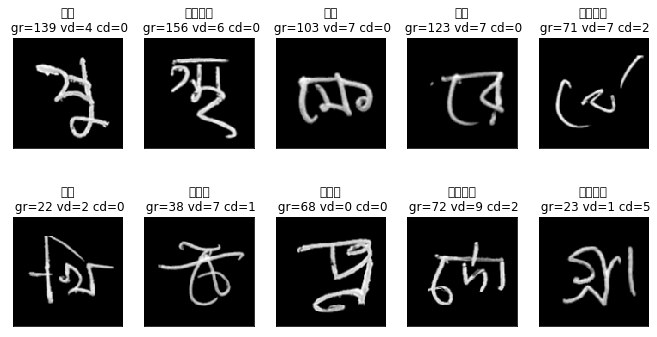

In [36]:
plot_gallery2(list(image_list.values()), list(df.newlabel), 2,5)

In [40]:
labels = ['ষু', 'স্মৃ', 'ফে', 'রে','র্থে']

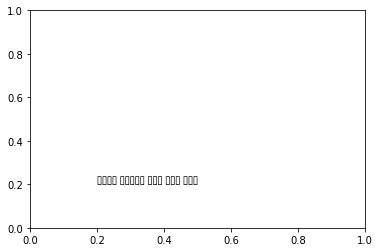

In [18]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

prop = fm.FontProperties(fname='kalpurush ANSI.ttf')
matplotlib.rcParams['font.family'] = prop.get_name()

s = u"কৃষক জমিতে ধান চাষ করে"
x = 0.2
y = 0.2
plt.text(x, y, s, fontproperties=prop)
plt.show()

In [ ]:
import matplotlib.pyplot as pyplot
from matplotlib.font_manager import FontProperties

if __name__ == "__main__":
    pyplot.figure() 
    prop = FontProperties()
    s = u"কৃষক জমিতে ধান চাষ করে"
    prop.set_file('kalpurush ANSI.ttf')
    pyplot.xlabel(s, fontproperties=prop)
    pyplot.show()

In [ ]:
train_df.head()

In [ ]:
test_df = pd.read_csv("../bengaliai-cv19/test.csv")
train_df = pd.read_csv("../bengaliai-cv19/train.csv")

In [ ]:
print(re.findall(r'\d+', "he2341llo 34"))

In [ ]:
image_list

In [ ]:
sorted(image_list)

In [ ]:
train_df = pd.read_csv("../bengaliai-cv19/train.csv")
labels = train_df.take(idx)

In [ ]:
labels

In [ ]:
labels.grapheme_root + labels.vowel_diacritic + 

In [ ]:
! rm ~/.cache/matplotlib

In [22]:
train_df.take(idx)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
186534,Train_186534,139,4,0,ষু
78566,Train_78566,156,6,0,স্মৃ
57585,Train_57585,103,7,0,ফে
152003,Train_152003,123,7,0,রে
114056,Train_114056,71,7,2,র্থে
60329,Train_60329,22,2,0,খি
191048,Train_191048,38,7,1,চেঁ
31600,Train_31600,68,0,0,ত্ন
134386,Train_134386,72,9,2,র্দো
49963,Train_49963,23,1,5,গ্রা


In [35]:
df["newlabel"] = df["grapheme"] +  "\n gr=" + df["grapheme_root"].astype(str) + " vd=" + df["vowel_diacritic"].astype(str) + " cd=" + df["consonant_diacritic"].astype(str)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
df = train_df.take(idx)

In [28]:
df

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,newlabel
186534,Train_186534,139,4,0,ষু,gr=139 vd=4 cd=0
78566,Train_78566,156,6,0,স্মৃ,gr=156 vd=6 cd=0
57585,Train_57585,103,7,0,ফে,gr=103 vd=7 cd=0
152003,Train_152003,123,7,0,রে,gr=123 vd=7 cd=0
114056,Train_114056,71,7,2,র্থে,gr=71 vd=7 cd=2
60329,Train_60329,22,2,0,খি,gr=22 vd=2 cd=0
191048,Train_191048,38,7,1,চেঁ,gr=38 vd=7 cd=1
31600,Train_31600,68,0,0,ত্ন,gr=68 vd=0 cd=0
134386,Train_134386,72,9,2,র্দো,gr=72 vd=9 cd=2
49963,Train_49963,23,1,5,গ্রা,gr=23 vd=1 cd=5
